# Sources
[Dataset](https://www.kaggle.com/dhruvildave/english-handwritten-characters-dataset?select=english.csv)

[Paper](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.163.2718)

# Creation of Model

In [ ]:
%pylab inline

import os
from google.colab import drive
import numpy as np
import pandas as pd
import glob

from fastai.vision import *
from torch.nn.functional import *

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_dir = '/content/drive/My Drive/Stage 4/Data'

In [ ]:
labels = pd.read_csv(data_dir + '/labels.csv')

Loading data and labels from directory

In [ ]:
data = ImageDataBunch.from_df(path = data_dir,
                              df=labels, 
                              valid_pct=0.1, 
                              fn_col='image', 
                              label_col='label',
                              ds_tfms=get_transforms(), 
                              bs=50,
                              size=256).normalize(imagenet_stats)

In [ ]:
model = cnn_learner(data, models.resnet50, metrics=accuracy, loss_func = nn.CrossEntropyLoss())

Summary of our model

In [ ]:
model.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
___________________________________________________

# Finding best learning rate for the model

In [ ]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


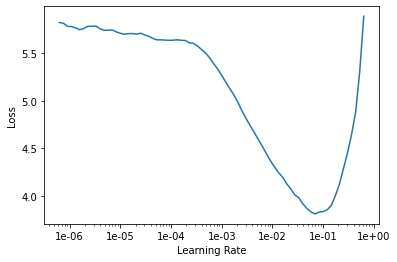

In [ ]:
model.recorder.plot()

# Training Model

In [ ]:
lr = 5e-3
model.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.536968,1.740521,0.569930,03:26
1,1.558903,0.925822,0.751748,02:17
2,1.060643,0.871969,0.779720,02:18
3,0.757062,0.764658,0.807692,02:18


Unfreezing the rest of the layers and finding a new learning rate

In [ ]:
model.unfreeze()

In [ ]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


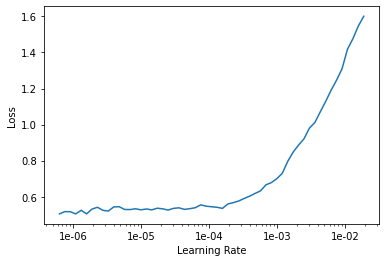

In [ ]:

model.recorder.plot()

Training model with new learning rate

In [ ]:
lr = 1e-6
model.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.547608,0.724975,0.807692,02:22
1,0.565245,0.737135,0.811189,02:24
2,0.572463,0.743994,0.804196,02:24
3,0.547550,0.723401,0.814685,02:25
4,0.553852,0.721093,0.818182,02:24
5,0.544028,0.724581,0.811189,02:24
6,0.516556,0.717181,0.821678,02:24
7,0.520729,0.720755,0.814685,02:23


# Visualization of Training Results

In [ ]:
interp = ClassificationInterpretation.from_learner(model)

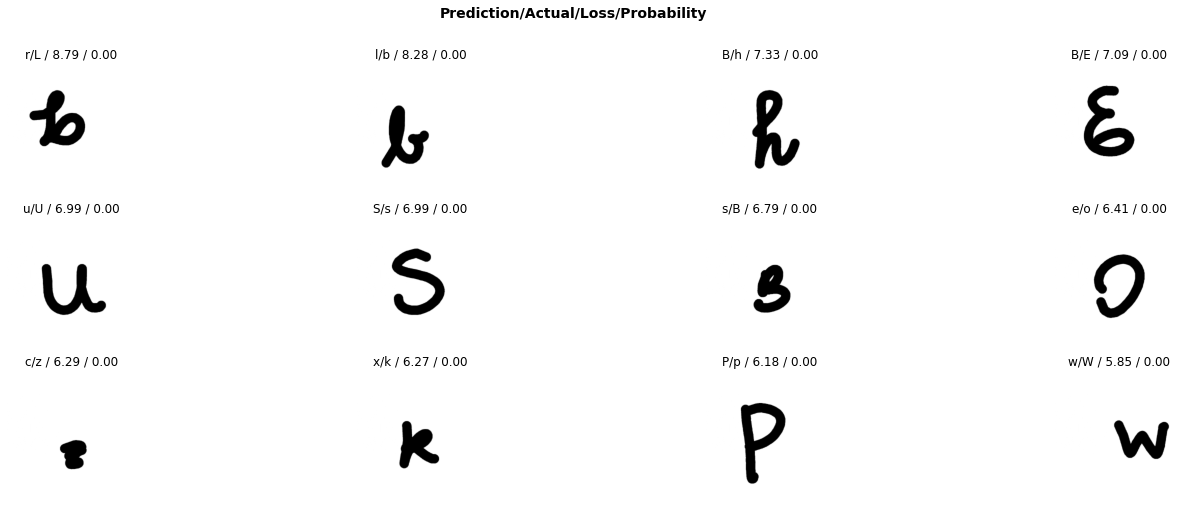

In [ ]:
interp.plot_top_losses(k=12, figsize=(24,8))

# Passing Data into Model

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
  def bb_letter(img):
    copy = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    ROI_number = 0
    for c in cnts:
      x,y,w,h = cv2.boundingRect(c)
      ROI = img[y:y+h, x:x+w]
      cv2.rectangle(copy,(x,y),(x+w,y+h),(36,255,12),2)
      ROI_number += 1
      
    cv2_imshow(copy)
    cv2.waitKey()

Passing in an image and returning the predicted label

Predicted Label: I


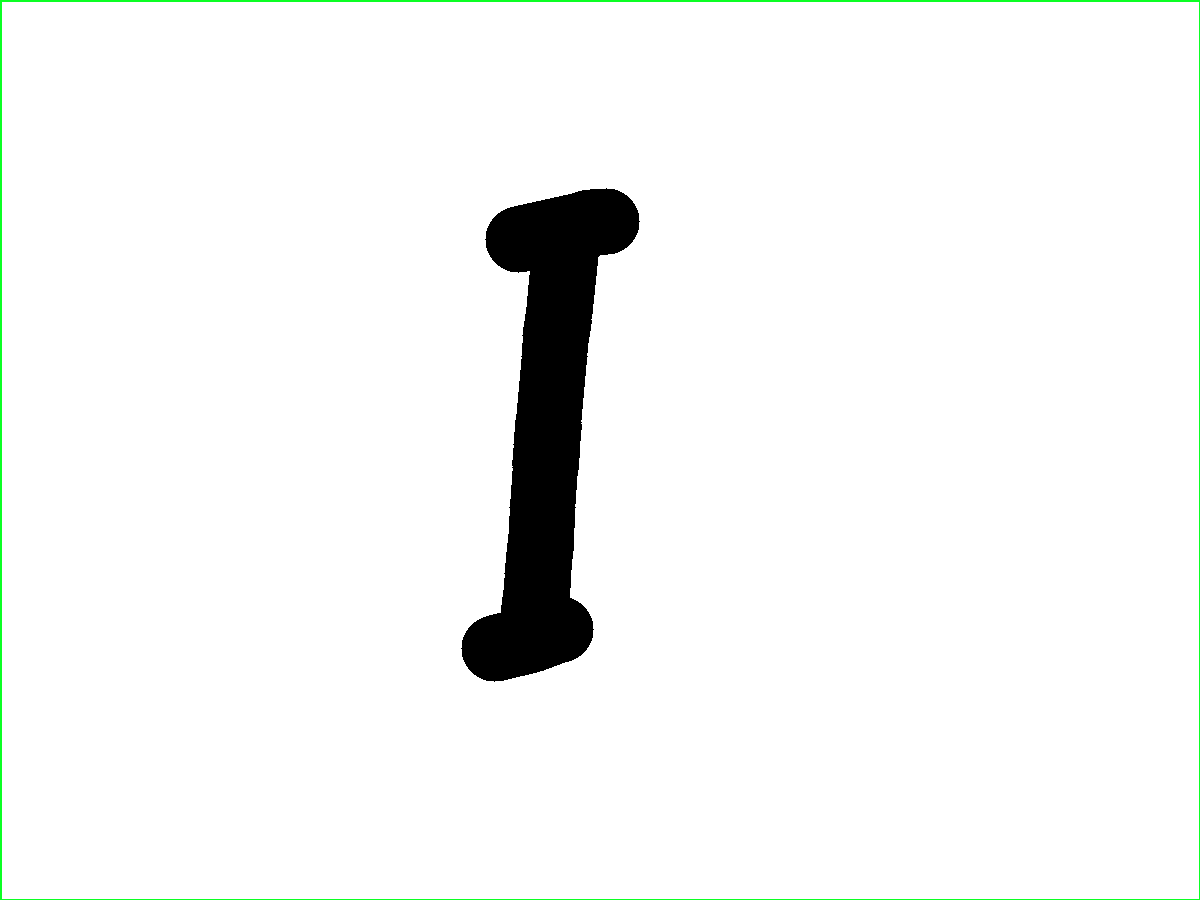

In [ ]:
test_path = '/content/drive/MyDrive/Stage 4/Data/Img/img019-010.png'
test_img = cv2.imread(test_path)
pred, actual, _= model.predict(open_image(test_path))
print(f'Predicted Label: {pred}')
#cv2_imshow(test_img)
bb_letter(test_img)

# Calculating Percision, Recall, and Accuracy of the Test Set

In [ ]:
preds, y = model.get_preds(ds_type=DatasetType.Valid)
acc = accuracy(preds, y)

In [ ]:
preds, targs = model.get_preds(ds_type=DatasetType.Valid)
acc = accuracy(preds, targs)

In [66]:
cfm = interp.confusion_matrix()
cfm = np.nan_to_num(cfm)

FP = cfm.sum(axis=0) - np.diag(cfm) 
FN = cfm.sum(axis=1) - np.diag(cfm) 
TP = np.diag(cfm)
TN = cfm.sum() - (FP + FN + TP)

percision = (TP / (TP + FP))
recall = (TP / (TP + FN))

percision = np.nan_to_num(percision)
recall = np.nan_to_num(recall)

In [68]:
print(f"Percision: {percision.sum()} \nRecall: {recall.sum()} \nAccuracy: {acc * 100}%")

Percision: 43.356460206460206 
Recall: 41.64754689754689 
Accuracy: 81.4685287475586%


# Parsing a Word into individual letters and passing each letter into the model

In [ ]:
%pip install gTTS

Parsing image into individual characters

In [75]:
  def extract_letter(img):
    inv = 255 - img
    gray = cv2.cvtColor(inv, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    index = 0
    for box in contours:
      x,y,w,h = cv2.boundingRect(box)
      bb = img[y:y + h, x:x + w]
      cv2_imshow(bb)
      cv2.imwrite(f'/content/drive/MyDrive/Stage 4/Handwriting Test/temp/img_{index}.png', bb)
      index += 1

Showing parsed letters

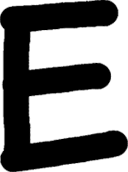

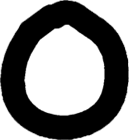

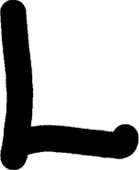

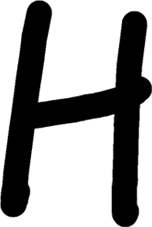

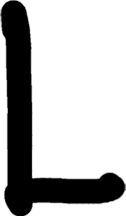

In [76]:
test_path = '/content/drive/MyDrive/Stage 4/Handwriting Test/hello3.png'
test_img = cv2.imread(test_path)

extract_letter(test_img)

Passing letters into model

In [ ]:
dir = '/content/drive/MyDrive/Stage 4/Handwriting Test/temp/'
pred_letters = []
for filename in os.listdir(dir):
    f = os.path.join(dir, filename)
    if os.path.isfile(f):
        pred, actual, _ = model.predict(open_image(f))
        pred_letters.append(pred)
        os.remove(f)

Results from model

In [79]:
string = ''
for t in pred_letters:
  string += str(t)
print(string)

BOLfI


Converting string to speech and saving the output as an MP3

In [ ]:
from gtts import gTTS
language = 'en'
text_to_speech = gTTS(text=string, lang=language, slow=False)
text_to_speech.save("/content/drive/MyDrive/Stage 4/output.mp3")